# DEEP METRIC LEARNING: SKIN CANCER DATASET TRAINING


## LOADING DATA AND PREPROCESSING

In [1]:
import matplotlib.pyplot as plt
import helper
import torch
from torchvision import datasets, transforms, models
import numpy as np
import zipfile
import csv
import pandas as pd
import seaborn as sn
import datasets_skin, losses, train
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data.dataloader import default_collate # to get the dataloader into cuda
import torch.optim.lr_scheduler as lr_scheduler # adjust learning rate

Instructions to import the data:
- Load the dataset as zip file from https://www.kaggle.com/datasets/andrewmvd/isic-2019
- unzip it from the drive
- create a folder ISIC_training that contains the folder ISIC_2019
- use torchvision datatasets.imagefolder to load the big data


In [2]:
# FIRST LOAD THE FILE FROM THE DRIVE TO THE WORKSPACE
# !unzip /content/drive/MyDrive/ISIC_Training/ISIC_2019_Training_Input.zip

In [3]:
# normalize with the values in the documentation https://pytorch.org/hub/pytorch_vision_resnet/
preprocess = transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder('/content/ISIC_training', transform=preprocess)

In [4]:
## Define a function to plot tensor images in the format loaded

def imshow(tensor, title=None):
    """Imshow for Tensor."""
    tensor = tensor[0] # take only the tensor and not the class 0
    tensor = tensor.numpy().transpose((1, 2, 0)) # you have to transpose an image like this because imshow want the channels as last coordinates
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    plt.imshow(tensor)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Device is cuda
<class 'torchvision.datasets.folder.ImageFolder'>
<class 'tuple'>
<class 'torch.Tensor'>
25331
torch.Size([3, 224, 224])


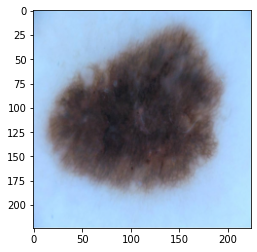

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.get_device_name()
print('Device is', device)
# some technical info about the dataset object
print(type(dataset))
print(type(dataset[0]))
print(type(dataset[0][0]))
print(len(dataset))
print(dataset[0][0].size()) # the images have values between 0 and 1
imshow(dataset[0])
plt.show()

In [6]:
# LOAD LABELS from csv text file

labels_dir = '/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv'
file = open(labels_dir)
csvreader = csv.reader(file)
header = []
header = next(csvreader)
header = header[1:]
print('names of the labels',header) 

rows = []
for row in csvreader:
    rows.append(row[1:]) # skip the first element which is the image name
file.close()

labels = dict() # initialize a dictionary to convert labels with their names
for i in range(len(header)):
        labels[i+1] = header[i]
print('dictionary of the labels',labels) # dictionary of the labels and their corresponding names
y_array = np.array(rows)
print(y_array.shape) # is not the shape we want for labels 
y = []
for row in y_array:
        for i in range(9):
                if row[i]=='1.0':
                        y.append(i+1)
y = np.array(y)
print('shape of data labels', y.shape)



names of the labels ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
dictionary of the labels {1: 'MEL', 2: 'NV', 3: 'BCC', 4: 'AK', 5: 'BKL', 6: 'DF', 7: 'VASC', 8: 'SCC', 9: 'UNK'}
(25331, 9)
shape of data labels (25331,)


In [7]:
# CHECK IF THE CLASSES ARE BALANCED

labels_unique = np.unique(y)
## labels dictionary of the labels
print(labels_unique, 'notice that the ninth label is missing')
N = len(dataset)
x = 0
N_class = []
for i in labels_unique:
    p = len(y[y==i])
    N_class.append(p)
    x += p
print(x) # check if we counted all the images
# no balanced at all!!!
prior_prob = [p / N for p in N_class]
print('The prior probabilities of the classes considering the complete dataset', prior_prob)


# subset the data by taking the first 177731 observation, more or less 80% of the training

x_train = torch.utils.data.Subset(dataset, list(range(17731)))


x_test = torch.utils.data.Subset(dataset, list(range(17731, 25331)))

y_train = y[0:17731]
y_test = y[17731:]

print('The length of the training set is', len(x_train))
print('The length of the test set is', len(x_test))

######## Compute again the prior prob for the train set: ########

x = 0
N = len(y_train)
prior_prob = []
for i in labels_unique:
    p = len(y_train[y_train==i])
    prior_prob.append(p)
    x += p
print(x) # check if we counted all the images
# no balanced at all!!!
prior_prob = [p / N for p in prior_prob]
print('The prior probabilities of the classes after the partition are', prior_prob)
# more or less are the same so we decide that this split into training and test is good

[1 2 3 4 5 6 7 8] notice that the ninth label is missing
25331
The prior probabilities of the classes considering the complete dataset [0.1785164423038964, 0.5082704985985551, 0.1311831352887766, 0.034226836682326005, 0.1035884884134065, 0.009435079546800363, 0.009987762030713354, 0.02479175713552564]
The length of the training set is 17731
The length of the test set is 7600
17731
The prior probabilities of the classes after the partition are [0.15864869437707968, 0.5793243471885399, 0.09068862444306582, 0.023123343297050365, 0.10794653431842535, 0.009192938920534657, 0.009982516496531499, 0.02109300095877277]


In [8]:
for i in labels_unique:
  # print(f'The number of images in class {labels[i]} is {N_class[i-1]} with prior prob {prior_prob[i-1]} \\')

  print(labels[i], ': ', prior_prob[i-1])

MEL :  0.15864869437707968
NV :  0.5793243471885399
BCC :  0.09068862444306582
AK :  0.023123343297050365
BKL :  0.10794653431842535
DF :  0.009192938920534657
VASC :  0.009982516496531499
SCC :  0.02109300095877277


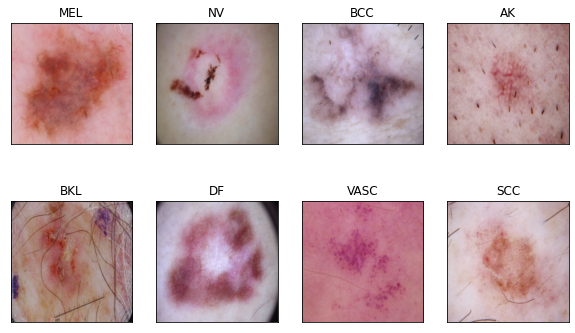

In [9]:
### plot one image per class total 8
fig, axes= plt.subplots (2,4, figsize= (10,6))
for i in range(len(labels_unique)):
  if i<4:
    indices = np.where(y_train==i+1)
    tensor = x_train[int(indices[0][100])]
    tensor = tensor[0] # take only the tensor and not the class 0
    tensor = tensor.numpy().transpose((1, 2, 0)) # you have to transpose an image like this because imshow want the channels as last coordinates
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    axes[0,i].imshow(tensor)
    axes[0, i].set_title(labels[i+1])
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
  else:
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    indices = np.where(y_train==i+1)
    tensor = x_train[int(indices[0][100])]
    tensor = tensor[0] # take only the tensor and not the class 0
    tensor = tensor.numpy().transpose((1, 2, 0)) # you have to transpose an image like this because imshow want the channels as last coordinates
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    axes[1, i-4].set_xticks([])
    axes[1, i-4].set_yticks([])
    axes[1, i-4].set_title(labels[i+1])
    axes[1, i-4].imshow(tensor)

plt.show()


## TRAINING NETWORK WITH CONTRASTIVE LOSS


 

In [10]:
train_data = datasets_skin.ContrastiveDataset(x_train, y_train,
                 train=True,
                 transform=transforms.ToTensor())
test_data = datasets_skin.ContrastiveDataset(x_test, y_test,
                 train=False,
                 transform=transforms.ToTensor())

batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [11]:
lr = 0.001
margin = 0.3
epochs = 3
print('working on',device)

# TRAINING CNN:

# model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
print('number of input features for the last fully connected layer is',num_ftrs)

for param in model.parameters(): # use the pretrained network as feature extractor
   param.requires_grad = False

# try to finetune the model
emb_dim = 4

model.fc = nn.Sequential(nn.Sigmoid(), nn.Linear(num_ftrs, emb_dim),
                         nn.Sigmoid()) # collapse everything between 0 and 1 in order the margin to have sense

model = model.to(device)
## ADAM optimizer 'Adaptive Moment Estimation' extends stochastic gradient descend
# set the parameters as in matlab tutorial
# Set the gradient decay factor to 0.9 and the squared gradient decay factor to 0.99 (default values in pytorch amdam)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, betas=(0.9, 0.999))

# loss_per_epoch_vector useful to plot the loss as a function of the epochs
# train_results useful in order to use k-NN to classify test data
loss_per_epoch_vector, train_results = train.fit_contrastive(train_dataloader, train_data, model, epochs,
                                                             opt=optimizer, labels=labels_unique, unsq=True, scheduler=None , device=device, margin=margin)
torch.save(model, f'skin_contrastive_margin={margin}.pth')
loss_per_epoch_vector_past=[0.1224, 0.1082, 0.1000, 0.0867, 0.0792]

working on cuda


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of input features for the last fully connected layer is 512


Epoch: 1/3 - Loss: 0.0120


Epoch: 2/3 - Loss: 0.0112


Epoch: 3/3 - Loss: 0.0110
Shape of the data in the learned metric space: (17731, 4)


## EVALUATION

In [12]:

test_data.set_train(False)
test_results = []
model.eval()
# # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time.
with torch.no_grad(): # the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation
    for i in test_data.index:
        image = test_data[i].unsqueeze(0)
        test_results.append(model(image.to(device)).cpu().numpy()) # convert the output of the network into numpy array

test_results = np.concatenate(test_results) # Join a sequence of arrays along an existing axis
print(test_results.shape) # 2 coordinates for all the 7600 images in the test set



(7600, 4)


Accuracy: 0.4381578947368421
7600
[1709, 2603, 1715, 457, 710, 76, 76, 254]
[0.44880047 0.34464599 0.14394383 0.01287303 0.04915155 0.
 0.         0.00058514]
[0.16634652 0.72339608 0.08567038 0.00076834 0.02381867 0.
 0.         0.        ]
[0.26530612 0.30029155 0.36618076 0.0180758  0.04431487 0.00116618
 0.         0.00466472]
[0.34792123 0.16630197 0.38949672 0.03719912 0.05251641 0.
 0.         0.00656455]
[0.32535211 0.37887324 0.22676056 0.01971831 0.04788732 0.
 0.         0.00140845]
[0.21052632 0.59210526 0.19736842 0.         0.         0.
 0.         0.        ]
[0.22368421 0.72368421 0.02631579 0.01315789 0.01315789 0.
 0.         0.        ]
[0.32677165 0.18110236 0.40944882 0.01181102 0.06299213 0.00393701
 0.         0.00393701]
[[4.48800468e-01 3.44645992e-01 1.43943827e-01 1.28730252e-02
  4.91515506e-02 0.00000000e+00 0.00000000e+00 5.85137507e-04]
 [1.66346523e-01 7.23396081e-01 8.56703803e-02 7.68344218e-04
  2.38186708e-02 0.00000000e+00 0.00000000e+00 0.00000000

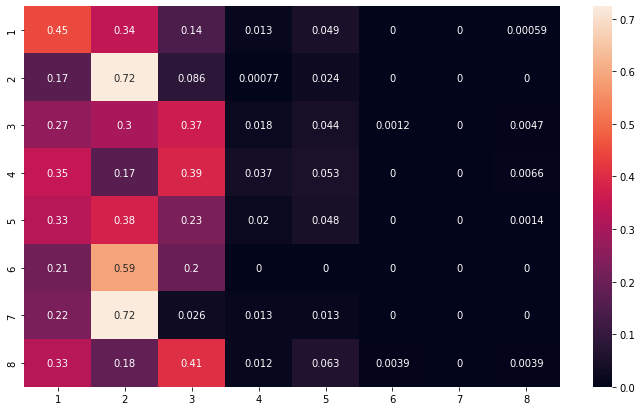

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_results, y_train)
y_pred = neigh.predict(test_results)
y_test = test_data.labels
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# 50 percent accuracy

# create vector of the different number of elements per class in the test set

x = 0
N = len(y_test)
N_class_test = []
for i in labels_unique:
    p = len(y_test[y_test==i])
    N_class_test.append(p)
    x += p
print(x)
print(N_class_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)

# modify the confusion matrix to get the percentage of classified in each class

x = np.zeros((8,8))
for i in range(len(N_class_test)):
  row = cf_matrix[i,:]/N_class_test[i]
  print(row)
  x[i,:] = row
print(x)


df_cm = pd.DataFrame(x, index = [i for i in labels_unique], columns = [i for i in labels_unique])
# to be modified because the classes are not balanced totally
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

## TRAINING NETWORK WITH TRIPLET LOSS

In [ ]:
import datasets_skin, losses, train, networks
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
from torch.utils.data.dataloader import default_collate # to get the dataloader into cuda
import torch.optim.lr_scheduler as lr_scheduler # adjust learning rate

train_data = datasets_skin.TripletDataset(x_train, y_train,
                 train=True,
                 transform=transforms.ToTensor())
test_data = datasets_skin.TripletDataset(x_test, y_test,
                 train=False,
                 transform=transforms.ToTensor())

batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

working on cuda


Epoch: 1/5 - Loss: 0.1710


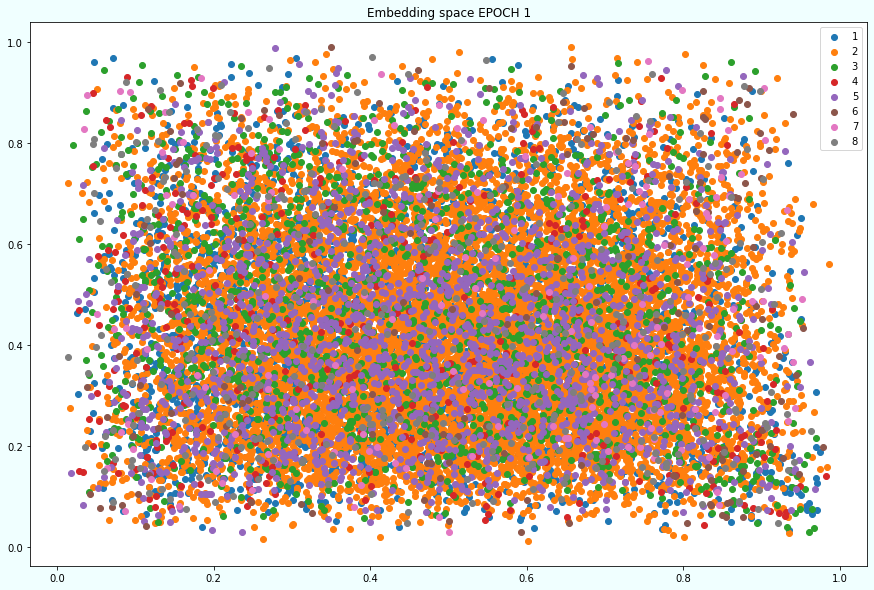

Epoch: 2/5 - Loss: 0.1659


Epoch: 3/5 - Loss: 0.1567


Epoch: 4/5 - Loss: 0.1536


Epoch: 5/5 - Loss: 0.1427


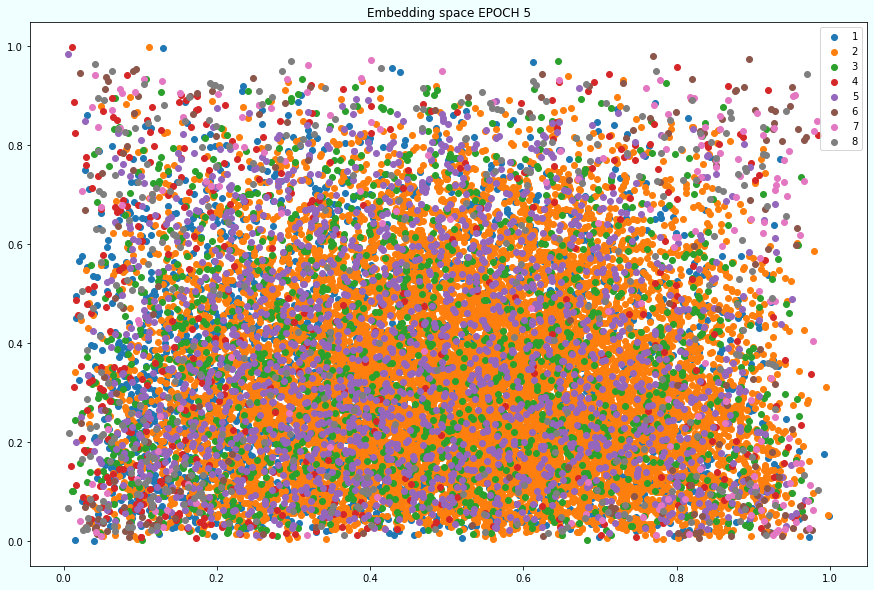

In [ ]:
lr = 0.0001 
margin = 0.15
epochs = 5
print('working on',device)

# TRAINING CNN:

model = networks.CNN_SKIN()
# model = models.resnet18(pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
# for param in model.parameters(): # use the pretrained network as feature extractor
#   param.requires_grad = False
# num_ftrs = model.fc.in_features
# print('number of input features for the last fully connected layer is', num_ftrs)

# model.fc = nn.Sequential(nn.Sigmoid(),
#                         nn.Linear(num_ftrs, 2),
#                         nn.Sigmoid()) # collapse everything between 0 and 1 in order the margin to have sense

model = model.to(device)

## ADAM optimizer 'Adaptive Moment Estimation' extends stochastic gradient descend
# set the parameters as in matlab tutorial
# Set the gradient decay factor to 0.9 and the squared gradient decay factor to 0.99 (default values in pytorch amdam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# loss_per_epoch_vector useful to plot the loss as a function of the epochs
# train_results useful in order to use k-NN to classify test data

loss_per_epoch_vector, train_results = train.fit_triplet(train_dataloader, train_data, model, epochs, epochs_toplot=[0,4], opt=optimizer, labels=labels_unique, unsq=True, scheduler=None , device=device, margin=margin)
torch.save(model, f'skin_triplet_margin={margin}.pth')